In [17]:
import genfig
# Installation via pip install -e ./genfig

from copy import deepcopy
import networkx as nx

# Helper functions:
import IPython.display

def show(data):
    """
    Display the given data using IPython display functions.

    Parameters:
    data (any): The data to be displayed. It can be of any type. If the data is not of type bytes, 
                it will be displayed directly. If the data is of type bytes and starts with '<?xml', 
                it will be displayed as an SVG. Otherwise, it will be displayed as an image.

    Returns:
    None
    """
    # If we got passed anything else, try displaying it directly
    if type(data) != bytes:
        display(data) 
    # SVG
    elif data.startswith(b'<?xml'):
        display(IPython.display.SVG(data))
    # Bitmap
    else:
        display(IPython.display.Image(data))


from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
def combine_images(images, output_path=None, margin=200, spacing=100, font_size=85, align='left', 
                   captions=list('abcdefghijkl'), scale=0.5):
    """
    Combine multiple images into a single image with padding and figure markers.

    Args:
        images (list of bytes): List of images, each in byte format.
        output_path (str, optional): Path to save the combined image. If None, the image is not saved.
        margin (int, optional): Margin around the combined image. Default is 200 pixels.
        spacing (int, optional): Spacing between images. Default is 100 pixels.
        font_size (int, optional): Font size for figure markers. Default is 72.

    Returns:
        PIL.Image.Image: The combined image.
    """

    # Load the images given as bytestrings, via file-like objects
    images = [Image.open(BytesIO(img)) for img in images]

    # Create a new image with the width of the widest image (+ margin) and height of all images combined
    max_width = max(i.width for i in images)
    width = max_width + margin * 2
    height = sum(i.height for i in images) + spacing * (len(images) - 1)
    combined_img = Image.new('RGB', (width, height), 'white')

    # Paste all images into the new image
    y_offset = 0
    for i in images:
        if align == 'left':
            x_offset = 0
        elif align == 'center':
            x_offset = (max_width - i.width) // 2
        elif align == 'right':
            x_offset = max_width - i.width
        else:
            raise ValueError(f'Invalid value for align: {align}')
        
        combined_img.paste(i, (margin + x_offset, y_offset))
        y_offset += i.height + spacing

    # Load a font
    font = ImageFont.load_default(font_size)

    # Create a drawing context
    draw = ImageDraw.Draw(combined_img)

    # Add figure markers
    y_offset = 0
    for im, caption in zip(images, captions):
        draw.text((10, y_offset), caption, fill="black", font=font)
        y_offset += im.height + spacing

    # Scale the image if needed
    if scale != 1:
        combined_img = combined_img.resize((int(width * scale), int(height * scale)), Image.Resampling.LANCZOS)

    # Save the new image
    if output_path:
        combined_img.save(output_path, dpi=(300,300))

    return combined_img


# Graph operators for cloning and analysis

This document describes two categories of graph operations called "derive" and "build", which differ fundamentally in how they handle sequence relationships. Build operations create new independent sequences: when you stitch or splice sequences together, or split them into pieces, you're constructing entirely new graphs that stand on their own. Derive operations, in contrast, maintain a shared backbone structure across all input and output graphs. When you find common variants with intersect, extract a region with detach, or combine variants with union, you preserve the context of variants in their original sequence framework. 

## Derive
### Subgraph & supergraph

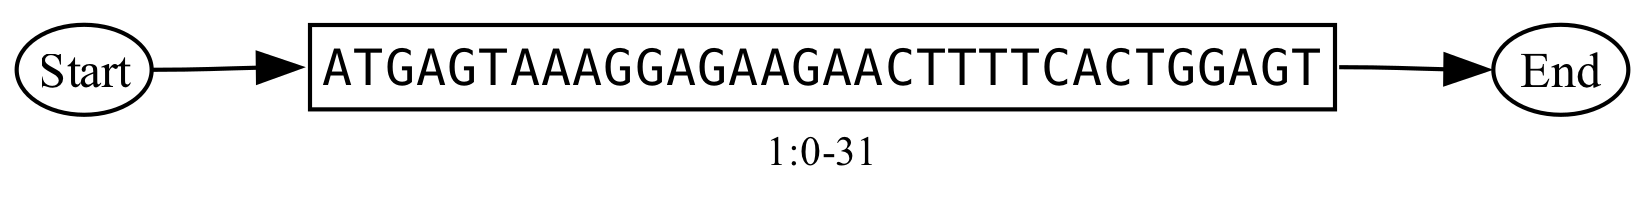

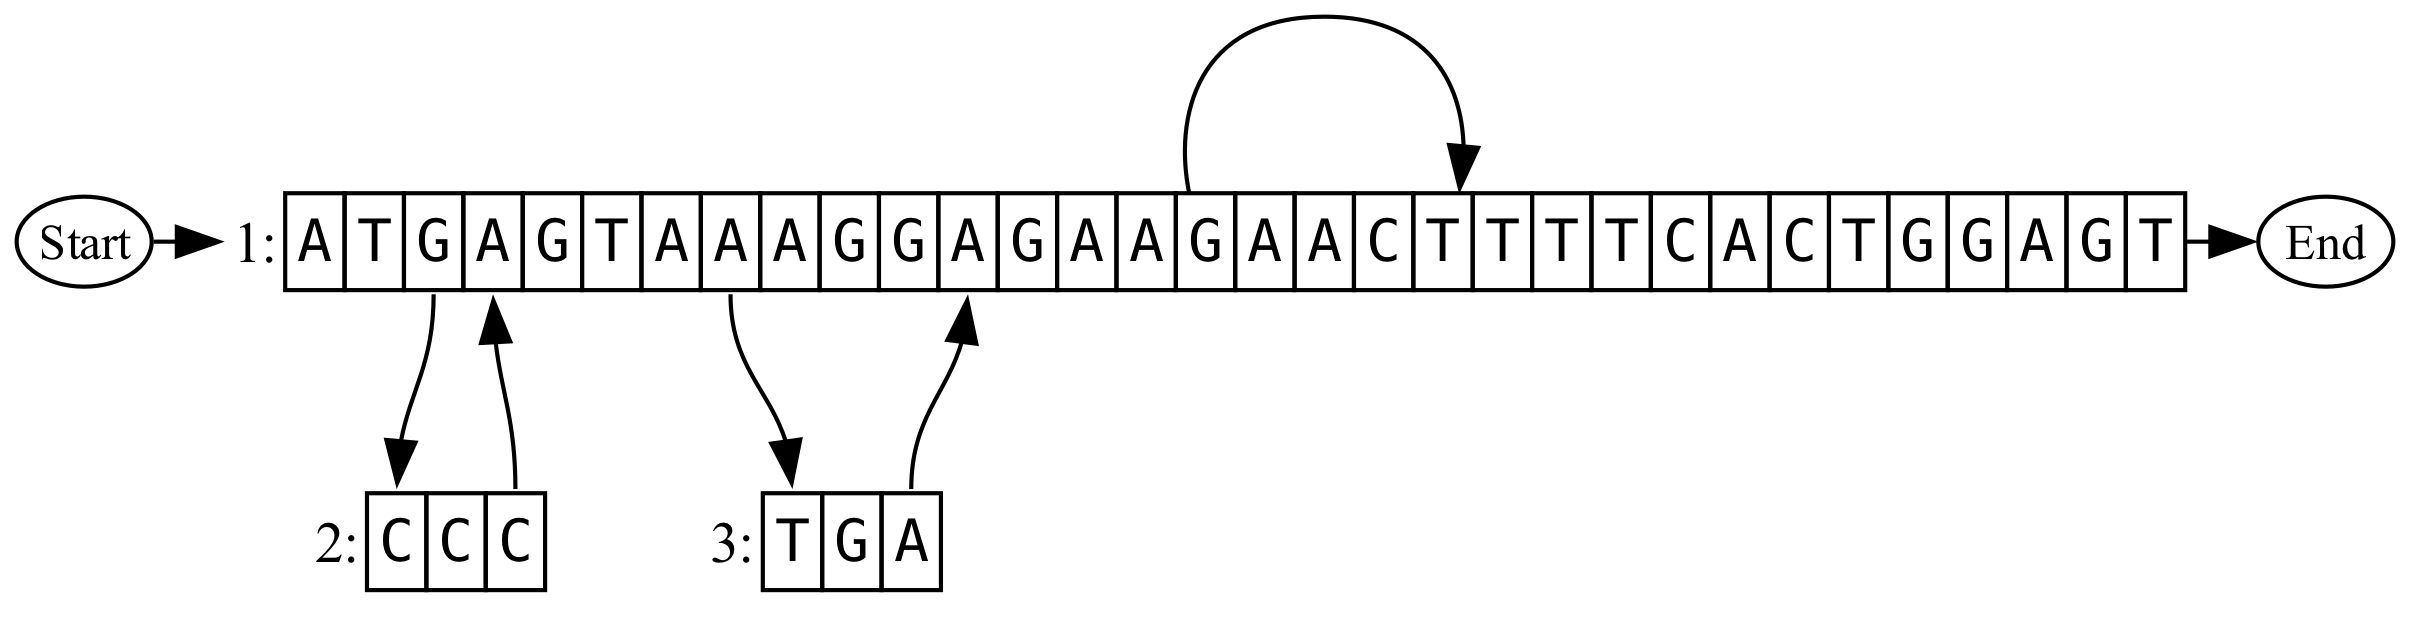

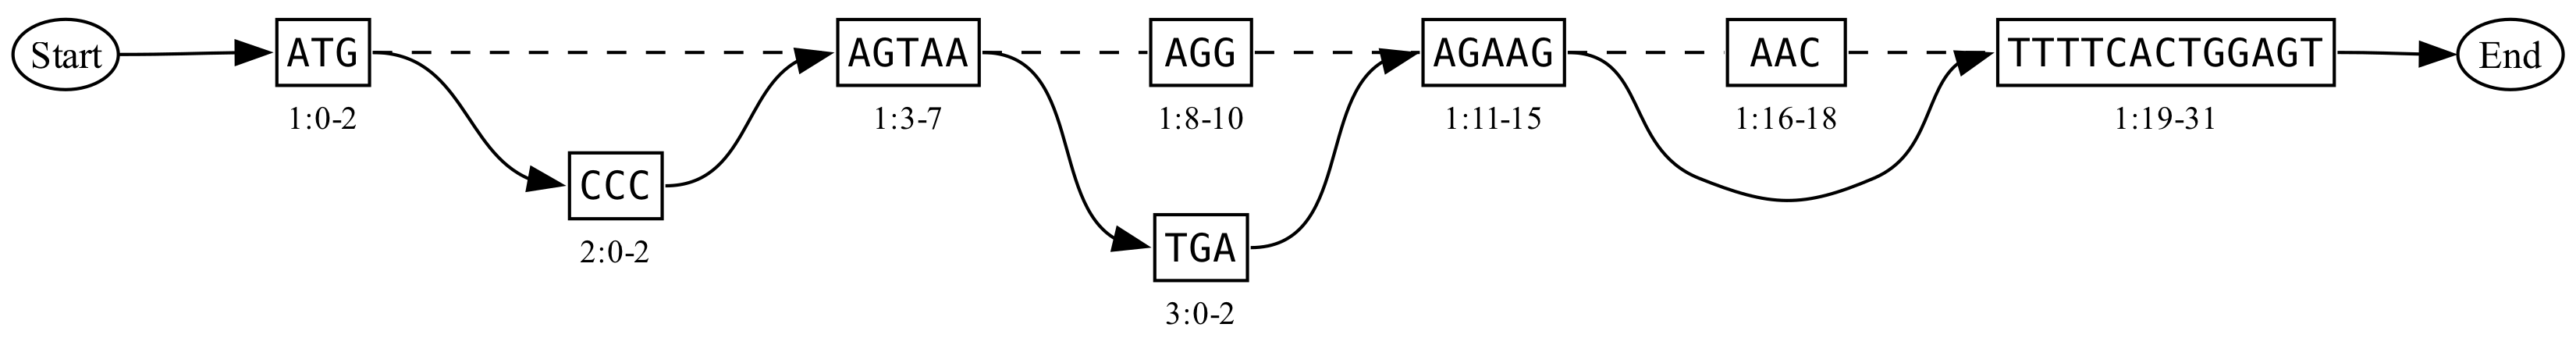

In [18]:
# Start with a linear reference
G_ref = genfig.Graph()
n1 = G_ref.add_node('ATGAGTAAAGGAGAAGAACTTTTCACTGGAGT') # Derived from BBa_K1896001
G_ref.connect_to_source(n1)
G_ref.connect_to_sink(n1)

# Then we make the total graph that includes everything:
G_all = deepcopy(G_ref)

# Insertion:
n2 = G_all.add_node('CCC')
G_all.add_edge((n1, 2), (n2, 0))
G_all.add_edge((n2, 2), (n1, 3))

# Substitution:
n3 = G_all.add_node('TGA')
G_all.add_edge((n1, 7), (n3, 0))
G_all.add_edge((n3, 2), (n1, 11))

# Deletion:
G_all.add_edge((n1, 15), (n1, 19))


show(G_ref.render_block_graph(format='png'))

edge_styling = {('2:2','1:3'):{'tailport':'2:n'}}
show(G_all.render_graph(format='png', edge_attributes=edge_styling))

show(G_all.render_block_graph(format='png'))





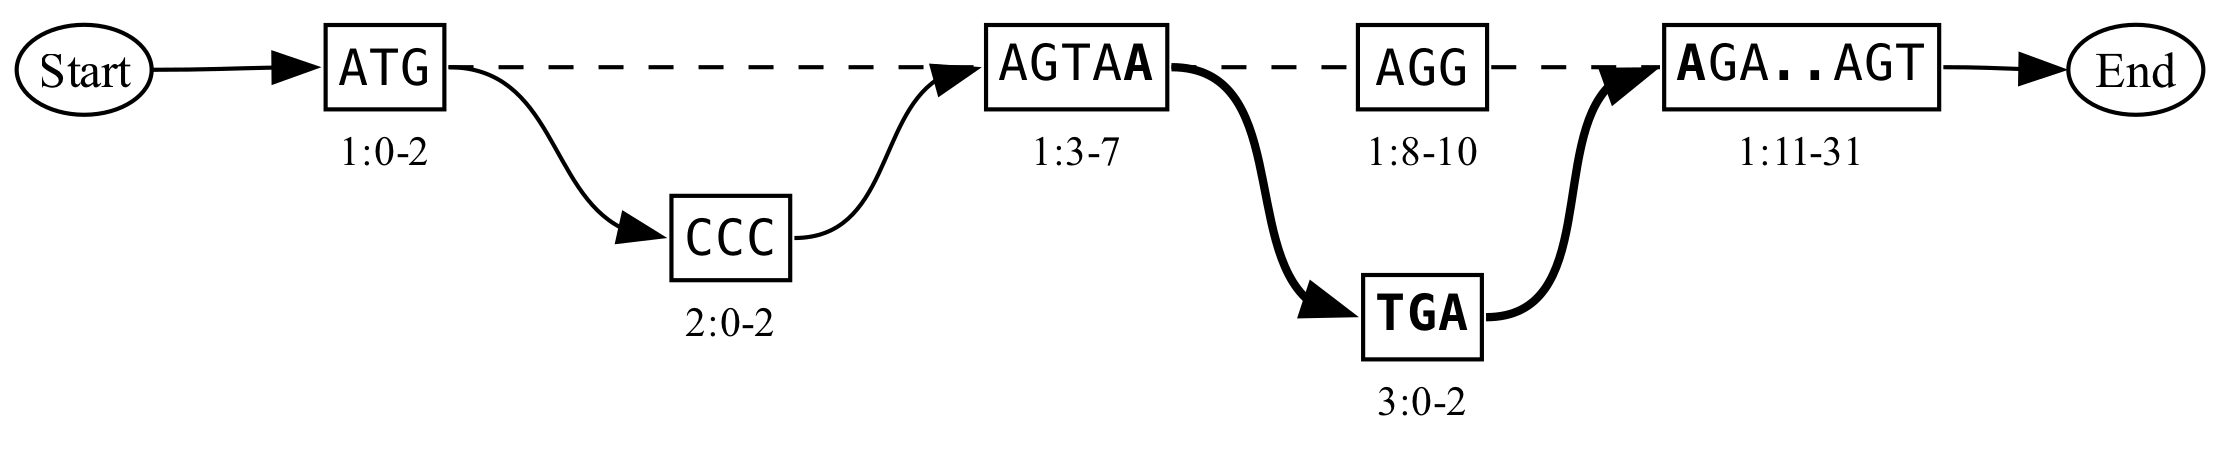

In [19]:
G1 = deepcopy(G_all)
G1.remove_edge((n1, 15), (n1, 19)) # Remove the deletion, it got too busy
G1.remove_highlights()
G1.highlight_ranges(n1, [(7, 8), (11,12)])
G1.highlight_ranges(n3, [(0, 3)])
G1.highlight_edge((n1, 7), (n3, 0))
G1.highlight_edge((n3, 2), (n1, 11))
show(G1.render_block_graph(format='png', minimize=True, graph_attributes={'ranksep':'0.4'}))


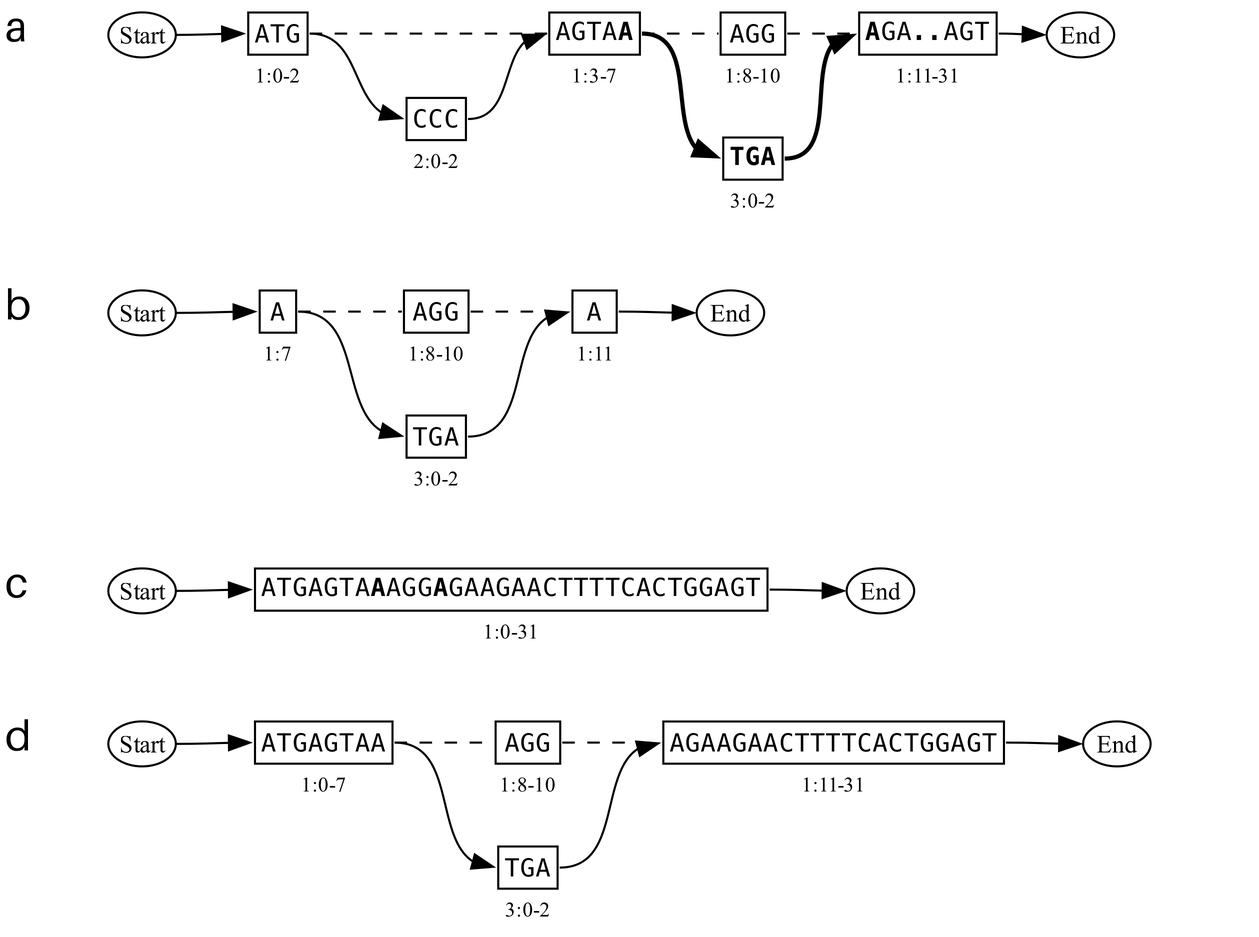

In [20]:
panels = []
# Subsetting extracts a subgraph, which is equivalent to moving the source and sink edges, 
# and then pruning everything that is no longer reachable

# Panel A has the original graph with highlights where the subset will happen:
G1 = deepcopy(G_all)
G1.remove_edge((n1, 15), (n1, 19)) # Remove the deletion, it got too busy
G1.remove_highlights()
G1.highlight_ranges(n1, [(7, 8), (11, 12)])
G1.highlight_ranges(n3, [(0, 3)])
G1.highlight_edge((n1, 7), (n3, 0))
G1.highlight_edge((n3, 2), (n1, 11))
# Style the implicit edges too:
#edge_styling = {('1.3','1.8'):{'penwidth':2},
#                ('1.8','1.11'):{'penwidth':2}}
edge_styling = {} # Implicit edges were getting confusing

panels.append(G1.render_block_graph(format='png', minimize=True, graph_attributes={'ranksep':'0.3'}, edge_attributes=edge_styling ))

# Panel B has the result of the subset operation:
# Define absolute coordinates as a node with linear coordinate
start = (1, 7)
end = (1, 11) 

Gx = G1.extract_subgraph(start, end)
Gx.remove_highlights()
panels.append(Gx.render_block_graph(format='png', minimize=True, graph_attributes={'ranksep':'0.3'}))

# Panel C has the original graph with highlights where the superset will attach:
G_ref.highlight_ranges(n1, [(7, 8), (11, 12)])
panels.append(G_ref.render_block_graph(format='png', minimize=False))

# Panel D has the result of the superset operation:
Ga = deepcopy(G_ref)
Ga.remove_highlights()

# Unlike a union operation, attaching does not retain the start and end edges of the subgraph,
# so we clip them manually here:
Gx.graph.remove_node('start')
Gx.graph.remove_node('end')

# Verify that there is at least one common node between the two graphs
assert len(Ga.get_nodes().intersection(Gx.get_nodes())) > 0

for node, seq in Gx.get_nodes().difference(Ga.get_nodes()):
    Ga.add_node(seq, node_id=node)

for edge in Gx.get_edges().difference(Ga.get_edges()):
    Ga.add_edge(*edge)


panels.append(Ga.render_block_graph(format='png', minimize=False, prune=False))

combine_images(panels,'operators/subgraph-supergraph.png')


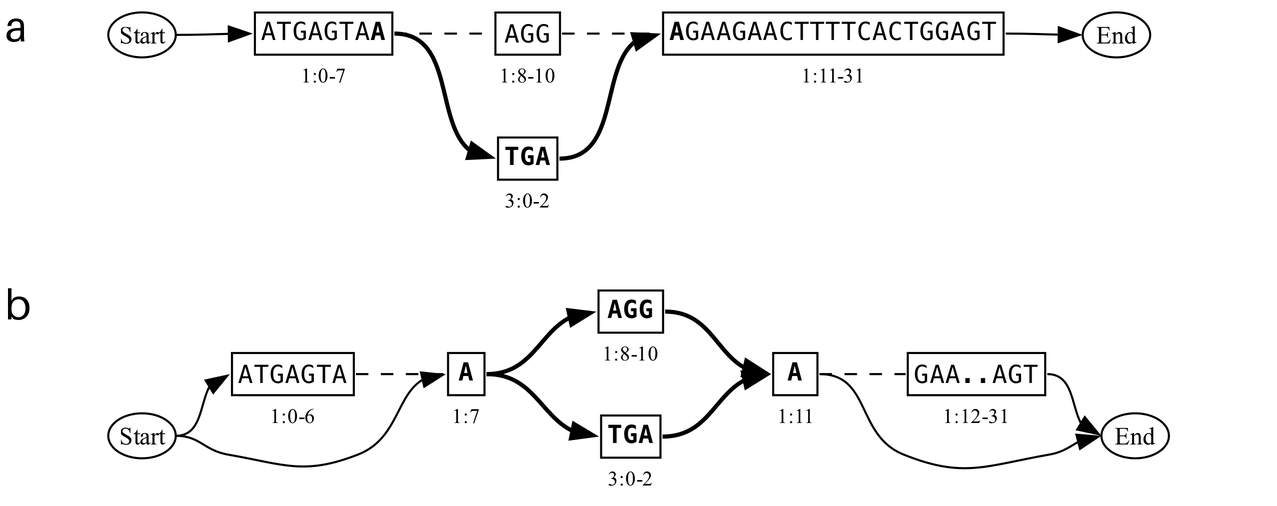

In [5]:
# Let's take a look at the difference between superset and union:
panels = []

Gu = deepcopy(G_ref)
n1 = '1'
n3 = '3'
Gx = G1.extract_subgraph((n1, 7), (n1, 11) )

# In this case we don't clip the start and end edges
for node, seq in Gx.get_nodes().difference(Gu.get_nodes()):
    Gu.add_node(seq, node_id=node)

for edge in Gx.get_edges().difference(Gu.get_edges()):
    Gu.add_edge(*edge)

# We also need to make the implicit edges explicit
Gu.add_edge((n1, 7), (n1, 8))
Gu.add_edge((n1, 10), (n1, 11))


# Add the highlights
for g in [Ga, Gu]:
    g.remove_highlights()
    g.highlight_edge((n1, 7), (n3, 0))
    g.highlight_edge((n3, 2), (n1, 11))

# Specific to the superset operation
Ga.highlight_ranges(n1, [(7, 8), (11, 12)])
Ga.highlight_ranges(n3, [(0, 3)])

# Specific to the union operation
Gu.highlight_ranges(n3, [(0, 3)])
Gu.highlight_ranges(n1, [(7, 12)])
Gu.highlight_edge((n1, 7), (n1, 8))
Gu.highlight_edge((n1, 10), (n1, 11))

#panels.append(G_ref.render_block_graph(format='png', minimize=False, align_blocks=True, splines=True))
#panels.append(Gx.render_block_graph(format='png', minimize=False, align_blocks=True, splines=True))

panels.append(Ga.render_block_graph(format='png', minimize=False, align_blocks=True, splines=True))

panels.append(Gu.render_block_graph(format='png', minimize=True, align_blocks=True, splines=True, graph_attributes={'ranksep':0.35}))

combine_images(panels,'operators/supergraph-union.png', align='left')

### Union/Intersection/Difference

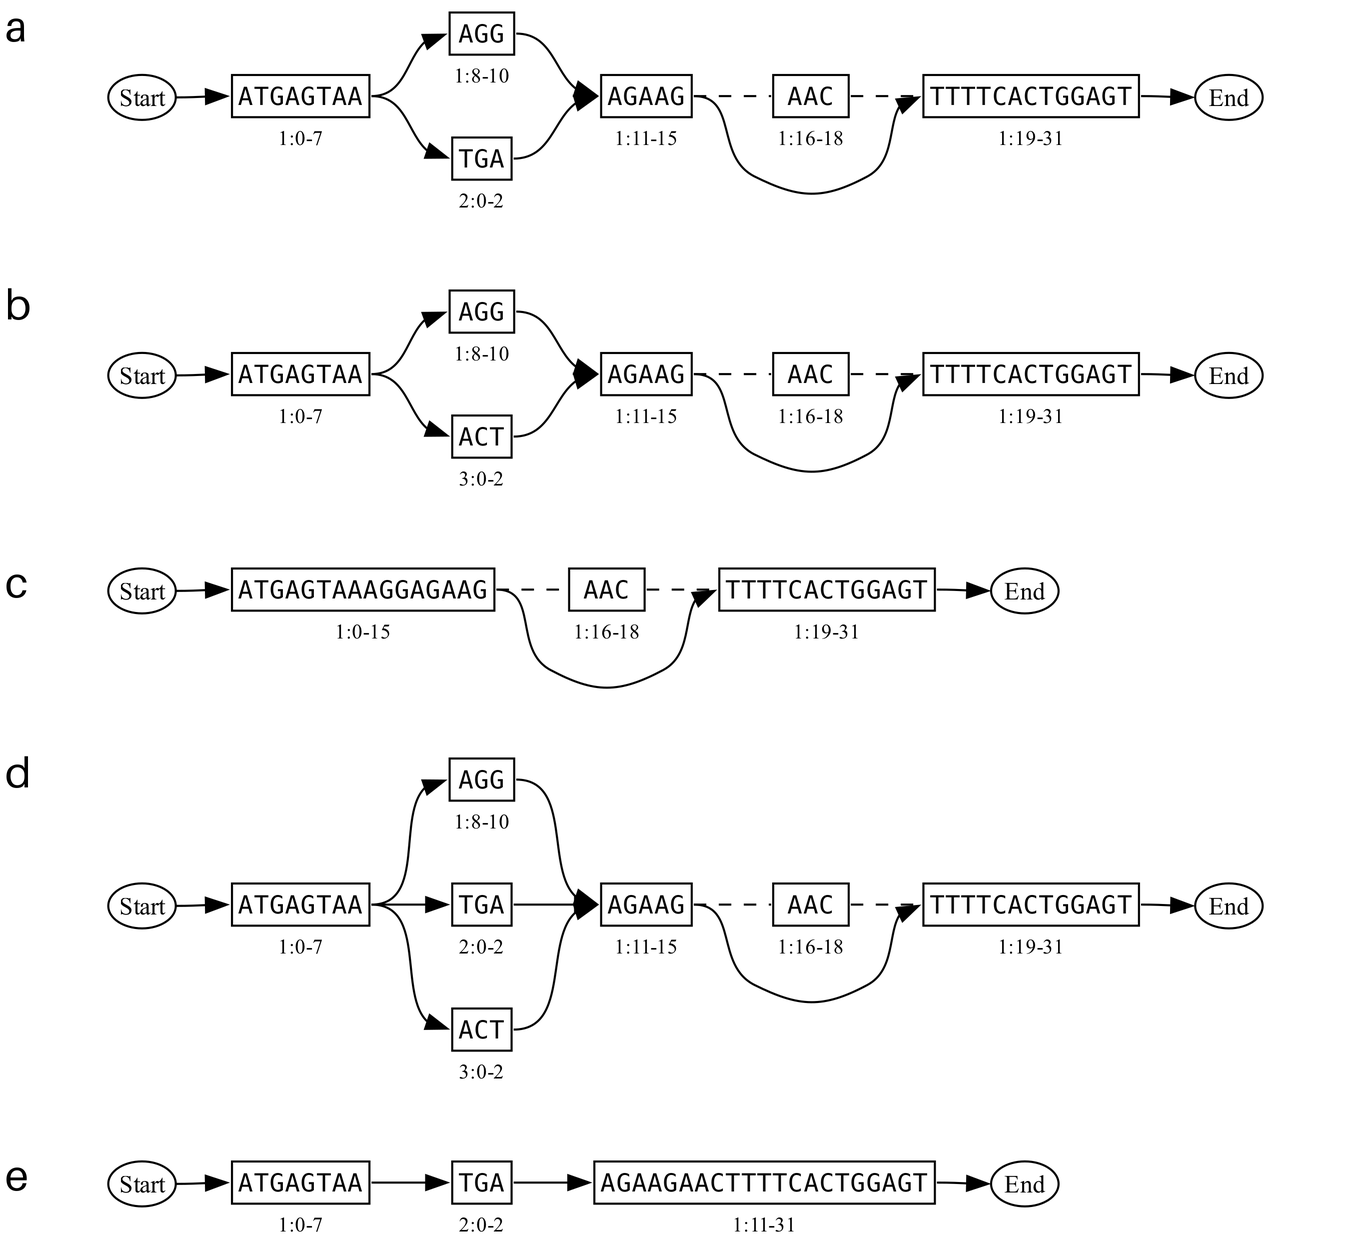

In [22]:

# Make the universe:
G_ref = genfig.Graph()
n1 = G_ref.add_node('ATGAGTAAAGGAGAAGAACTTTTCACTGGAGT') # Derived from BBa_K1896001
G_ref.connect_to_source(n1)
G_ref.connect_to_sink(n1)

G_all = deepcopy(G_ref)

# Deletion:
G_all.add_edge((n1, 15), (n1, 19))

# Substitutions:
n3 = G_all.add_node('TGA')
G_all.add_edge((n1, 7), (n3, 0))
G_all.add_edge((n3, 2), (n1, 11))
n4 = G_all.add_node('ACT')
G_all.add_edge((n1, 7), (n4, 0))
G_all.add_edge((n4, 2), (n1, 11))

panels = []


# Individual graphs:
# We represent G1 and G2 as diploids by turning implicit edges into explicit edges
G1 = deepcopy(G_all)
G1.remove_node(n4)
G1.add_edge((n1, 7), (n1, 8))
G1.add_edge((n1, 10), (n1, 11))
panels.append(G1.render_block_graph(format='png', align_blocks=True, graph_attributes={'ranksep':0.35}))

G2 = deepcopy(G_all)
G2.remove_node(n3)
G2.add_edge((n1, 7), (n1, 8))
G2.add_edge((n1, 10), (n1, 11))
panels.append(G2.render_block_graph(format='png', align_blocks=True, graph_attributes={'ranksep':0.35}))

# Intersection:
Gi = deepcopy(G1)
# We can't use the intersection function because that strips all the attributes
# Gi.graph = nx.intersection(G1.graph, G2.graph)

# Instead we find all the edges that are present in G1 and G2
common_edges = set(G1.get_edges()).intersection(set(G2.get_edges()))

for edge in Gi.get_edges():
    if edge not in common_edges:
        Gi.remove_edge(*edge)

# Remove internal edges that were made explicit
for (source, source_pos), (target, target_pos) in Gi.get_edges():
    if source == target and target_pos == source_pos + 1:
        Gi.remove_edge((source, source_pos), (target, target_pos))
        
panels.append(Gi.render_block_graph(format='png', align_blocks=True, graph_attributes={'ranksep':'0.35'}))

# Union:
Gu = deepcopy(G_all)
Gu.add_edge((n1, 7), (n1, 8))
Gu.add_edge((n1, 10), (n1, 11))
panels.append(Gu.render_block_graph(format='png', align_blocks=True, graph_attributes={'ranksep':'0.35'}))


# Difference:
only_in_G1 = set(G1.get_edges()).difference(set(G2.get_edges()))

for edge in G1.get_edges():
    if edge not in only_in_G1 and edge not in G_ref.get_edges():
        G1.remove_edge(*edge, prune=False)

panels.append(G1.render_block_graph(format='png', align_blocks=True, hide_nodes=['1.8'], graph_attributes={'ranksep':'0.35'}))

#captions = list('abcdefgh')
#captions[2] = 'c = a ∩ b' # Cairo can't render intersection symbol
combine_images(panels,'operators/intersect-union-difference.png', align='left')


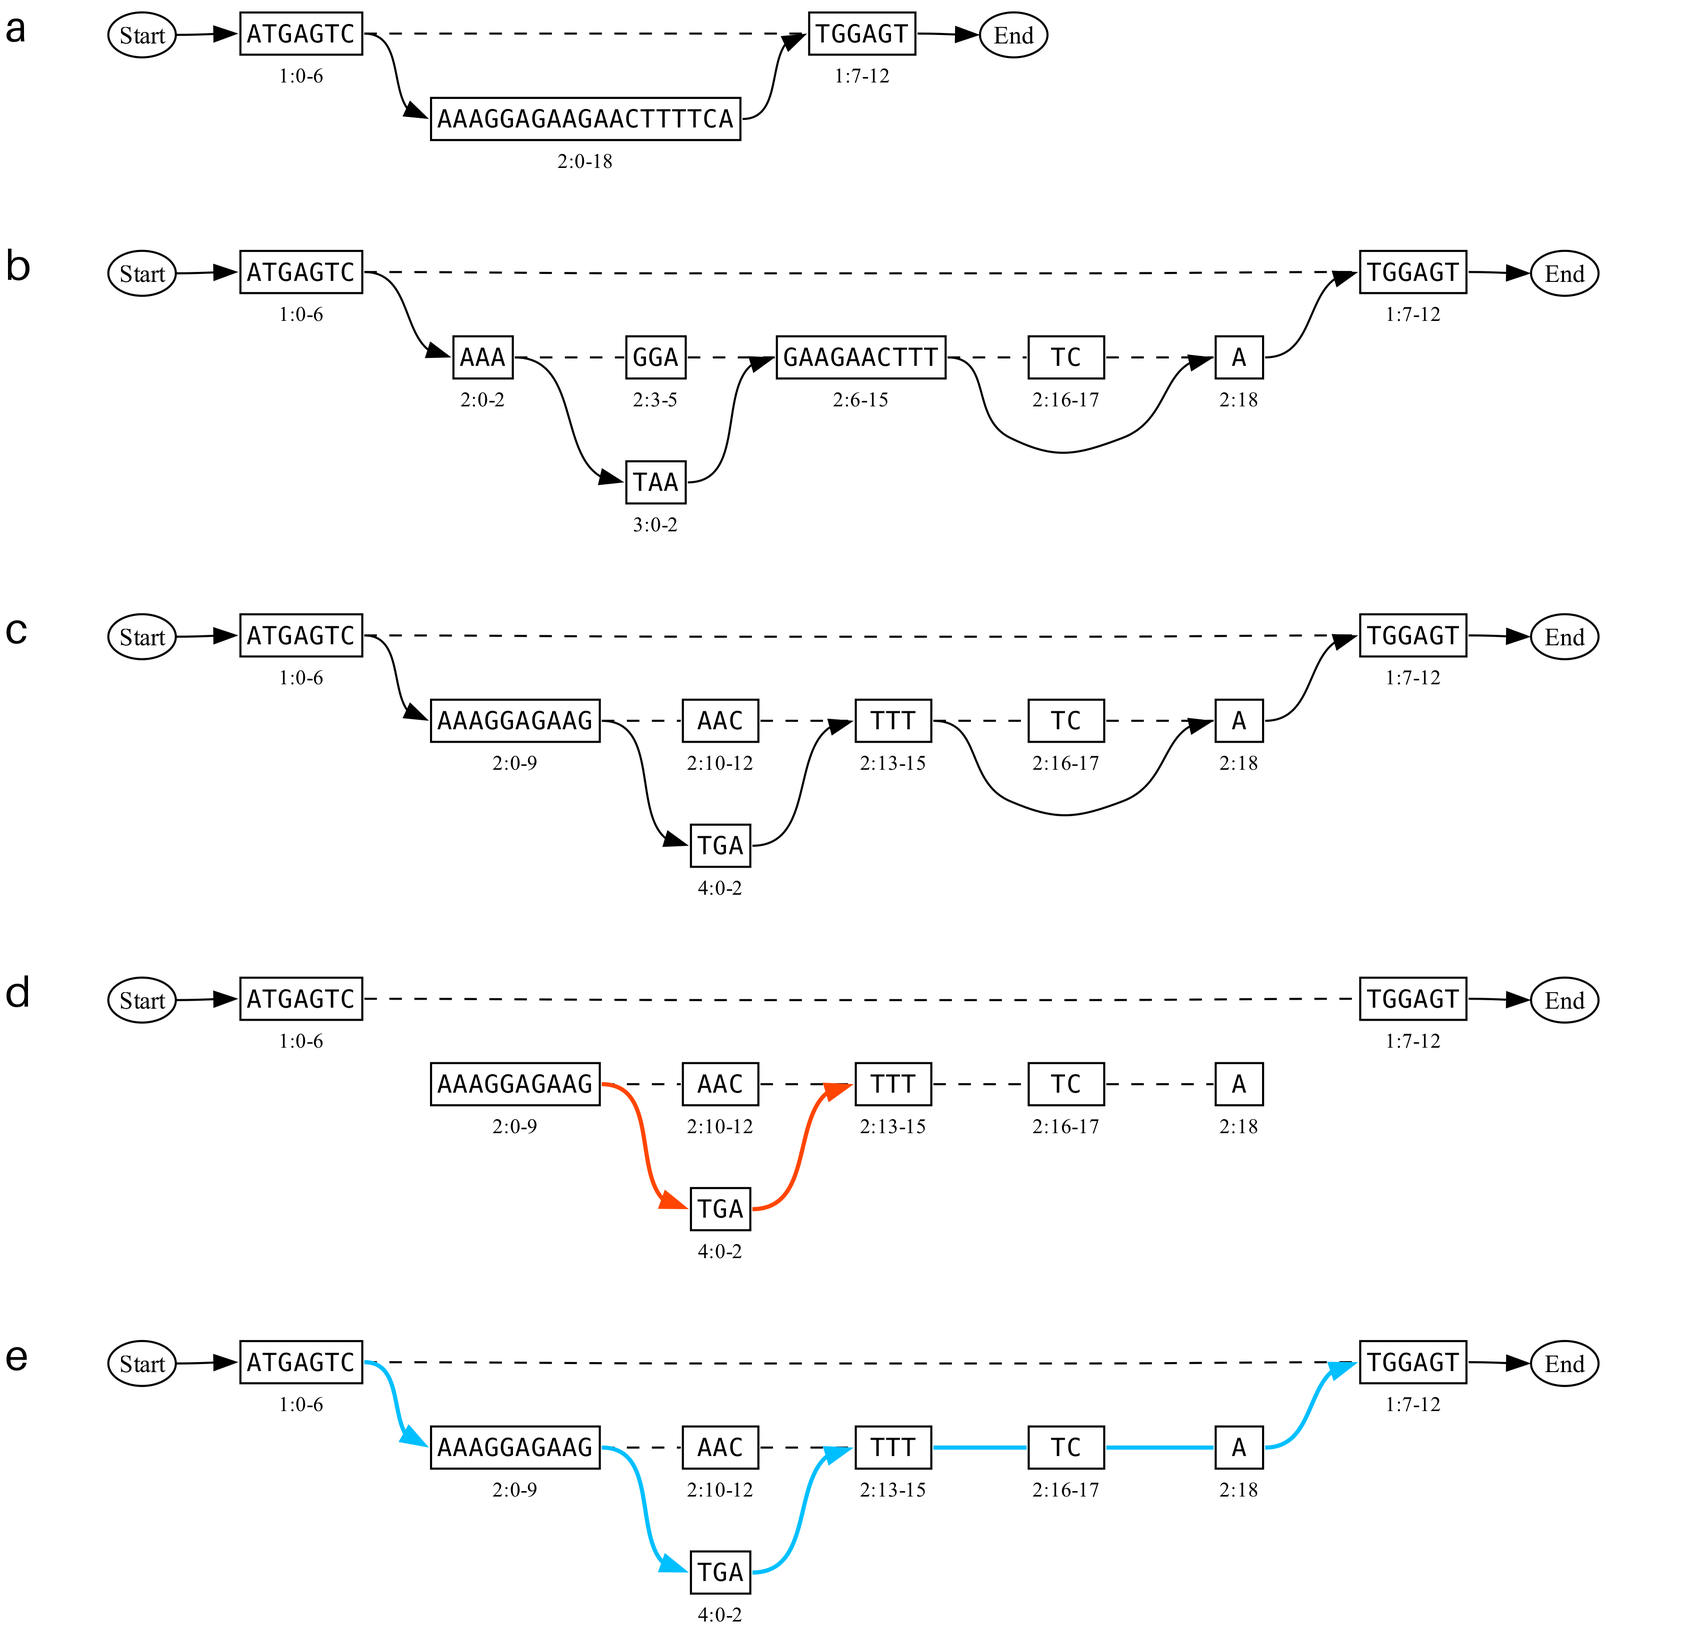

In [7]:
# Demonstrate how edges can end up getting detached if you don't have the right scaffold
G_0 = genfig.Graph()
n1 = G_0.add_node('ATGAGTCTGGAGT') # Derived from BBa_K1896001
G_0.connect_to_source(n1)
G_0.connect_to_sink(n1)

G1 = deepcopy(G_0)

G1.add_node('AAAGGAGAAGAACTTTTCA')
G1.add_edge((1,6),(2,0))
G1.add_edge((2,18),(1,7))

G2 = deepcopy(G1)
G2.add_node('TAA')
G2.add_edge((2,2),(3,0))
G2.add_edge((3,2),(2,6))
G2.add_edge((2,15),(2,18))

G3 = deepcopy(G1)
G3.add_node('TGA', node_id=4)
G3.add_edge((2,9),(4,0))
G3.add_edge((4,2),(2,13))
G3.add_edge((2,15),(2,18))


#show(G1.render_graph())
#show(G2.render_graph())

panels = []
graph_styling = {'ranksep':0.4,}

# Ref
#panels.append(G_0.render_block_graph(format='png', graph_attributes=graph_styling))

# First event
panels.append(G1.render_block_graph(format='png', graph_attributes=graph_styling))

# Second event
panels.append(G2.render_block_graph(format='png', graph_attributes=graph_styling))

# Second event - alt
panels.append(G3.render_block_graph(format='png', graph_attributes=graph_styling))

# Disconnection
marking =  {'color':'orangered', 'penwidth':'2'}
edge_styling = {('2.0','4.0'):marking,
                ('4.0', '2.13'):marking,
                ('1.0','2.0'):{'style':'invis'},
                ('2.18','1.7'):{'color':'invis'},
                ('2.13','2.18'):{'style':'invis'} }


panels.append(G3.render_block_graph(format='png', graph_attributes=graph_styling, edge_attributes=edge_styling))


# Reconnect backbone
marking =  {'color':'deepskyblue', 'penwidth':'2'}
edge_styling = {('2.0','4.0'):marking,
                ('4.0', '2.13'):marking,
                 ('1.0','2.0'):marking,
                 ('2.6','1.7'):marking,
                 ('2.13','2.18'):{'style':'invis'},
                 ('2.13','2.16'):{**marking, 'style':'solid'},
                 ('2.16','2.18'):{**marking, 'style':'solid'},
                 ('2.18','1.7'):marking }

panels.append(G3.render_block_graph(format='png', graph_attributes=graph_styling, edge_attributes=edge_styling))


combine_images(panels, 'operators/scaffold_edges.png')


## Split/ Stitch / Splice


```
               v
ATGAGTAAAGGAGAAGAACTTTTCACTGGAGT

without overlap:
ATGAGTAAAGGAGAAG
                AACTTTTCACTGGAGT


with overlap:

--overlap 4 left
ATGAGTAAAGGAGAAGAACT
                AACTTTTCACTGGAGT

--overlap 4 right
ATGAGTAAAGGAGAAG
            GAAGAACTTTTCACTGGAGT

--overlap 4 both
ATGAGTAAAGGAGAAGAA
              AGAACTTTTCACTGGAGT
```


Note: &#x2304; is a nicer looking marker for the split point


In [24]:
# Helper function to move the start or end pointer of a graph
def move_pointer(graph, pointer, position):
    """
    Move the start or end pointer of the graph to a new position with overlap.

    Args:
        graph (genfig.Graph): The graph to modify.
        pointer (str): The pointer to move, either 'start' or 'end'.
        position (int): The new position to move the pointer to.

    Returns:
        genfig.Graph: The modified graph.
    """
    graph_copy = deepcopy(graph)

    # Remove the original edges
    for edge in graph_copy.get_edges():
        (source, source_pos), (target, target_pos) = edge
        if pointer == 'end' and target == 'end':
            graph_copy.remove_edge(*edge)
            graph_copy.connect_to_sink(source, position)

        elif pointer == 'start' and source == 'start':
            graph_copy.remove_edge(*edge)
            graph_copy.connect_to_source(target, position)

    return graph_copy


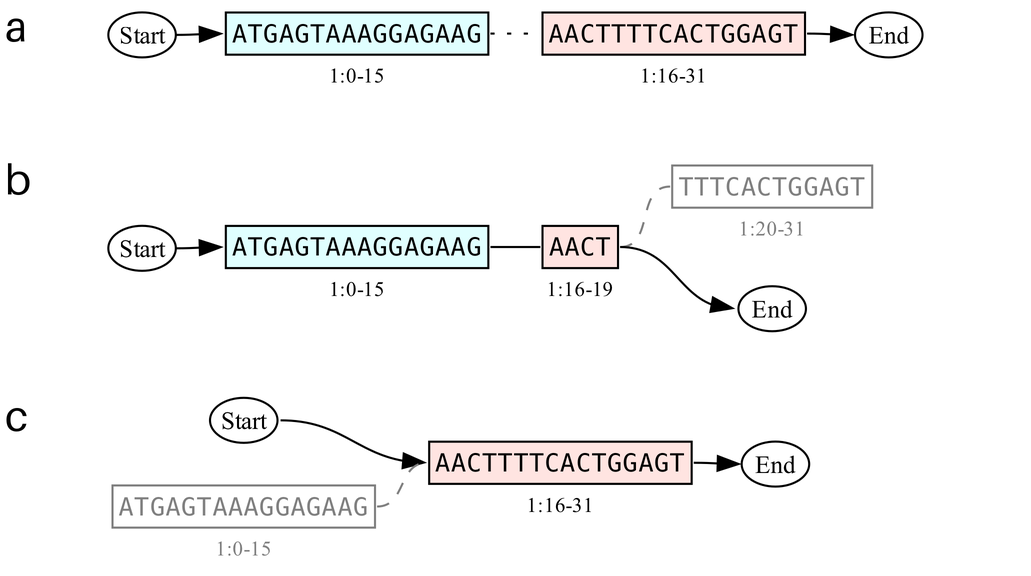

In [14]:
split_pos = 15
overlap = 4

panels = []
G_ref.remove_highlights()

G_start = deepcopy(G_ref)
G_start.add_edge(('1', split_pos), ('1', split_pos+1))

# Left overlap = overlap is attached only to the left part
edge_styling = {('1.0','1.16'):{'arrowhead':'none', 'style':'dotted'}}
node_styling = {'1.0':{'bgcolor':'lightcyan'},
                '1.16':{'bgcolor':'mistyrose'}}
panels.append(G_start.render_block_graph(format='png', edge_attributes=edge_styling, 
                                         node_attributes=node_styling, graph_attributes={'ranksep':0.3}))

G_left = move_pointer(G_ref, pointer='end', position=split_pos+overlap)
G_left.add_edge(('1', split_pos), ('1', split_pos+1))
edge_styling = {('1.0','1.16'):{'arrowhead':'none'},
                ('1.16','1.20'):{'style':'dashed', 'color':'gray50', 'arrowhead':'none'}}
node_styling = {'1.20':{'color':'gray50', 'fontcolor':'gray50'},
                '1.16':{'margin':0, 'width':0, 'bgcolor':'mistyrose'},
                '1.0':{'bgcolor':'lightcyan'}}
panels.append(G_left.render_block_graph(format='png', prune=False, align_blocks=False, 
                                        graph_attributes={'ranksep':0.3},
                                        edge_attributes=edge_styling, node_attributes=node_styling))

G_right = move_pointer(G_ref, pointer='start', position=split_pos+1)
G_right.add_edge(('1', split_pos), ('1', split_pos+1))
edge_styling = {('1.0','1.16'):{'arrowhead':'none', 'style':'dashed', 'color':'gray50'}}
node_styling = {'1.0':{'color':'gray50', 'fontcolor':'gray50'},
                '1.16':{'bgcolor':'mistyrose'}}
panels.append(G_right.render_block_graph(format='png', prune=False, align_blocks=False, 
                                         graph_attributes={'ranksep':0.3},
                                         edge_attributes=edge_styling, node_attributes=node_styling))

combine_images(panels,'operators/split_left.png')




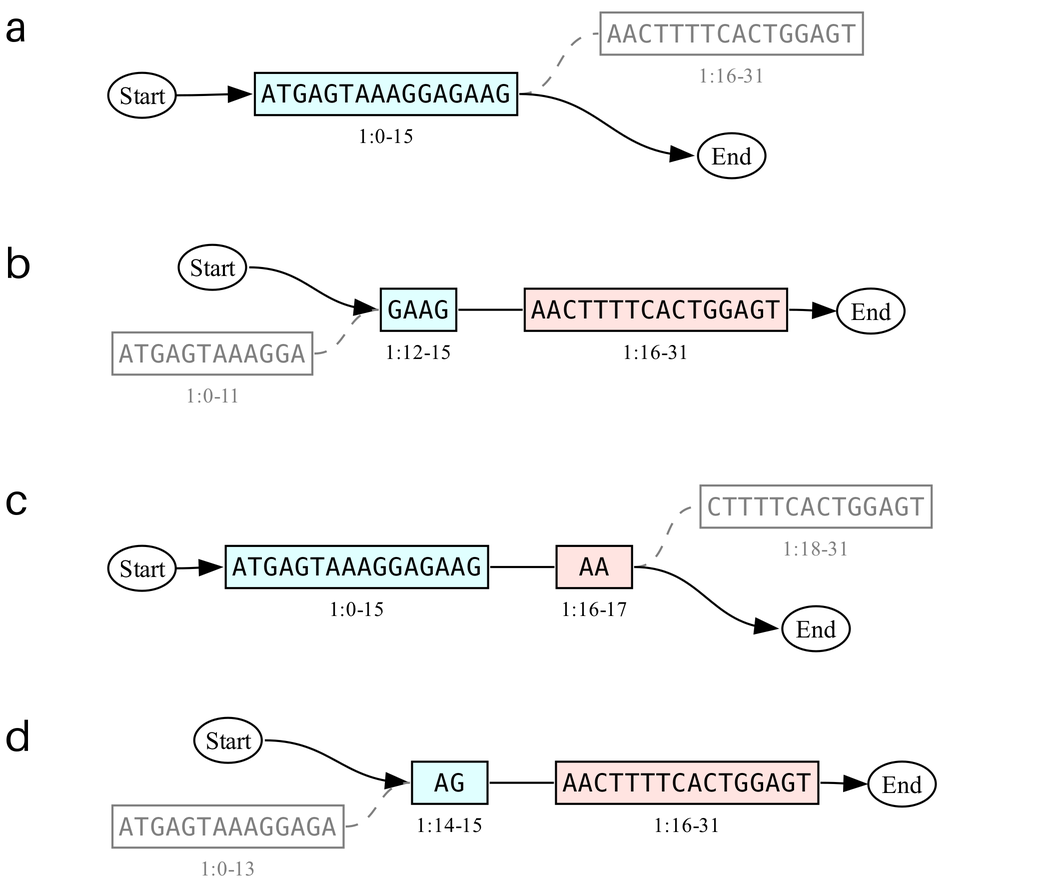

In [16]:
# Right overlap = overlap is attached only to the right part
panels = []

G_left = move_pointer(G_ref, pointer='end', position=split_pos)
G_left.add_edge(('1', split_pos), ('1', split_pos+1))
edge_styling = {('1.0','1.16'):{'arrowhead':'none', 'style':'dashed', 'color':'gray50'}}
node_styling = {'1.16':{'color':'gray50', 'fontcolor':'gray50'},
                '1.0':{'bgcolor':'lightcyan'}}
panels.append(G_left.render_block_graph(format='png', prune=False, align_blocks=False, 
                                        edge_attributes=edge_styling, node_attributes=node_styling,
                                        graph_attributes={'ranksep':0.5}))

G_right = move_pointer(G_ref, pointer='start', position=split_pos-overlap+1)
G_right.add_edge(('1', split_pos), ('1', split_pos+1))
edge_styling = {('1.0','1.12'):{'arrowhead':'none', 'style':'dashed', 'color':'gray50'},
                ('1.12','1.16'):{'arrowhead':'none'}}
node_styling = {'1.0':{'color':'gray50', 'fontcolor':'gray50'},
                '1.12':{'bgcolor':'lightcyan'},
                '1.16':{'bgcolor':'mistyrose'}}

panels.append(G_right.render_block_graph(format='png', prune=False, 
                                        align_blocks=False, 
                                        edge_attributes=edge_styling, node_attributes=node_styling,
                                        graph_attributes={'ranksep':0.3}))



# Both overlap = overlap is attached only to the right part
# Handle odd numbers for the overlap length
overlap_left = overlap // 2 + overlap % 2
overlap_right = overlap - overlap_left

G_left = move_pointer(G_ref, pointer='end', position=split_pos+overlap_left)
G_left.add_edge(('1', split_pos), ('1', split_pos+1))
edge_styling = {('1.16','1.18'):{'arrowhead':'none', 'style':'dashed', 'color':'gray50'},
                ('1.0','1.16'):{'arrowhead':'none'}}
node_styling = {'1.18':{'color':'gray50', 'fontcolor':'gray50'},
                '1.0':{'bgcolor':'lightcyan'},
                '1.16':{'bgcolor':'mistyrose'}}
panels.append(G_left.render_block_graph(format='png', prune=False, align_blocks=False, 
                                        edge_attributes=edge_styling, node_attributes=node_styling,
                                        graph_attributes={'ranksep':0.3}))

G_right = move_pointer(G_ref, pointer='start', position=split_pos-overlap_right+1)
G_right.add_edge(('1', split_pos), ('1', split_pos+1))
edge_styling = {('1.0','1.14'):{'arrowhead':'none', 'style':'dashed', 'color':'gray50'},
                ('1.14','1.16'):{'arrowhead':'none'}}

node_styling = {'1.0':{'color':'gray50', 'fontcolor':'gray50'},
                '1.14':{'bgcolor':'lightcyan'},
                '1.16':{'bgcolor':'mistyrose'}}

panels.append(G_right.render_block_graph(format='png', prune=False, 
                                        align_blocks=False, graph_attributes={'ranksep':0.3},
                                        edge_attributes=edge_styling, node_attributes=node_styling))

combine_images(panels,'operators/split_right_both.png')

## Stitch

In [12]:
# Open the dot files with pygraphviz
import pygraphviz as pgv

panels = []

G = pgv.AGraph('operators/stitch_before.dot')
G.layout(prog='dot')

def parse_pos(pos):
    return tuple(map(float, pos.split(',')))
def encode_pos(pos):
    return ','.join(map(str, pos))

# Move the nodes closer together:
top_row = ['start', '1', '2', 'end']
bottom_row = ['start2', '3', '4', 'end2']

node_pairs = list(zip(top_row, top_row[1:])) + list(zip(bottom_row, bottom_row[1:]))

for n1, n2 in node_pairs:
    x1, y1 = parse_pos(G.get_node(n1).attr['pos'])
    x2, y2 = parse_pos(G.get_node(n2).attr['pos'])
    w1 = float(G.get_node(n1).attr['width']) * 72
    w2 = float(G.get_node(n2).attr['width']) * 72

    spacing = 20
    x2 = x1 + w1/2 + spacing + w2/2

    # Make the virtual edge even shorter
    if G.get_edge(n1, n2).attr['arrowhead'] == 'none':
        x2 -= 24

    G.get_node(n2).attr['pos'] = encode_pos((x2, y2))


# Make the overlaps have the same x dimension
x1, y1 = parse_pos(G.get_node('2').attr['pos'])
x2, y2 = parse_pos(G.get_node('3').attr['pos'])
x_offset = x1 - x2
y_offset = 10

for node in bottom_row:
    x, y = parse_pos(G.get_node(node).attr['pos'])
    G.get_node(node).attr['pos'] = encode_pos((x + x_offset, y + y_offset))

base_img = G.draw(prog='neato', format='png:cairo', args='-n -Gdpi=300')


/Users/bvh/Git/gen/.venv/lib/python3.12/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: fixed cell size with unspecified width or height
in label of node 3

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


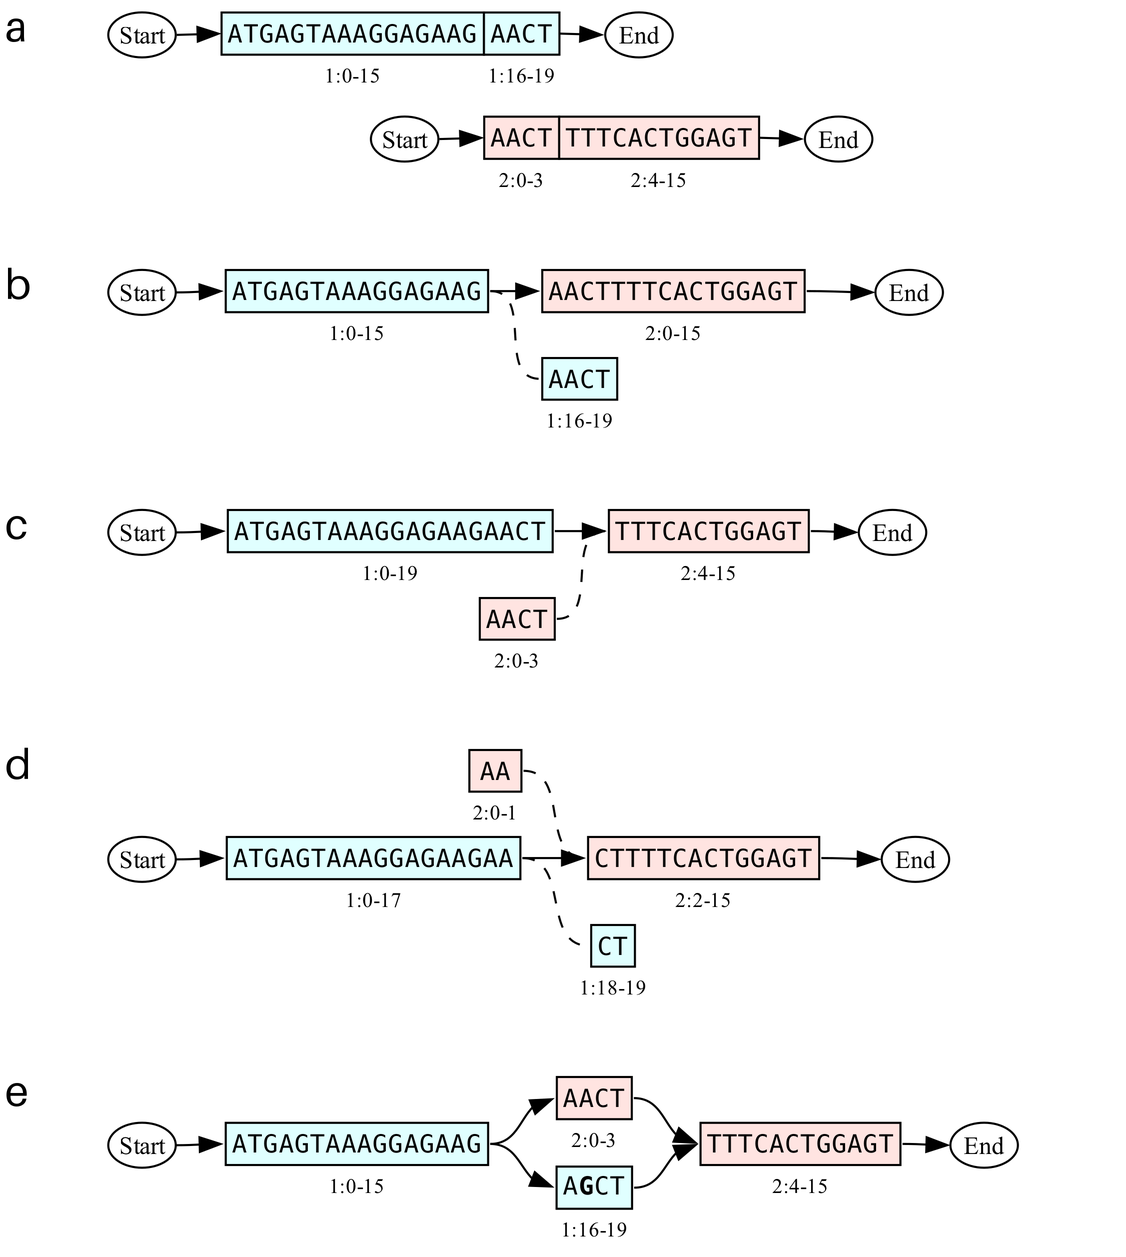

In [13]:
panels = [base_img]

# Left overlap
G = pgv.AGraph('operators/stitch_left.dot')
G.layout(prog='dot')
img = G.draw(prog='dot', format='png:cairo', args='-Gdpi=300')
panels.append(img)

# Right overlap
G = pgv.AGraph('operators/stitch_right.dot')
G.layout(prog='dot')
img = G.draw(prog='dot', format='png:cairo', args='-Gdpi=300')
panels.append(img)

# Both overlap
G = pgv.AGraph('operators/stitch_split.dot')
G.layout(prog='dot')
img = G.draw(prog='dot', format='png:cairo', args='-Gdpi=300')
panels.append(img)

# Left overlap with mismatch and "--mismatch keep" option (vs. "--mismatch drop" or the default "--mismatch error")
G = pgv.AGraph('operators/stitch_both.dot')
G.layout(prog='dot', args='-Granksep=0.3')
img = G.draw(prog='dot', format='png:cairo', args='-Gdpi=300')
panels.append(img)

combine_images(panels,'operators/stitches.png')